In [16]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np

#Import library code
import helper_code.dataloading as dataloading
import helper_code.model_functions as model_functions
import helper_code.data_vis as data_vis

In [17]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [18]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [19]:
train['label'].value_counts() / len(train['label'])

label
0    0.518692
1    0.481308
Name: count, dtype: float64

In [20]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="val_embeddings")

In [21]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [22]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [23]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [24]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']
img_urls = db_df['img_url']
a_ids = db_df['annotation_id']

In [25]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.502572,0.039140,-0.236639,1.061735,-0.092698,0.060341,0.472755,0.198981,-1.207637,-0.679688,...,1.015248,0.249089,0.052981,-0.064075,-0.660569,-0.236719,-1.434904,-0.759012,0.720741,-1.655582
1,1.035267,1.098646,-0.290841,-0.605239,-1.268639,-0.259969,0.735688,0.000234,-1.752981,-1.133535,...,0.869204,0.049013,0.336617,0.048816,0.365601,0.706692,-1.487064,0.004794,0.514950,0.149541
2,0.355949,0.145751,-0.195939,1.097845,-0.271564,0.622109,-0.182798,0.258746,-1.286518,-1.391399,...,1.283330,0.242736,0.268048,-0.454101,-0.582636,0.295915,-1.455115,-0.573718,1.105036,-1.879586
3,1.133721,1.125785,-0.084402,-0.153120,-1.087403,-0.271068,1.002080,-0.256303,-1.519419,-1.307463,...,0.290440,0.034407,0.612959,0.031046,0.434426,0.726922,-1.341635,0.263444,0.802009,-0.214949
4,0.722279,0.521510,-0.669492,0.044142,-0.721018,-0.032728,0.615472,-0.214225,-1.687640,-1.715953,...,0.659647,0.120266,0.335379,0.225937,0.115670,0.935813,-1.569199,-0.035802,1.473081,-1.078685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.372243,0.200836,0.135755,1.340643,-0.065360,0.011686,0.067772,0.328774,-1.558317,-1.194370,...,1.026867,0.254052,-0.052488,-0.183565,-0.896925,0.039406,-1.382736,-0.865631,0.435749,-1.504081
1494,0.171228,0.022852,-0.089878,0.855218,0.287207,0.698478,0.038763,0.260304,-1.205323,-1.271256,...,1.378499,0.234062,0.389963,-0.279269,-0.541094,0.431164,-1.630979,-0.647005,0.799180,-1.532913
1495,1.174448,0.973022,-0.269903,-0.216771,-1.003923,-0.805529,0.574992,-0.270664,-1.819458,-1.238461,...,0.219713,0.042255,0.644795,0.170532,0.463862,0.508496,-1.136975,0.500669,0.668929,-0.105998
1496,0.568998,0.440948,-0.039055,0.486898,-0.288797,0.835851,0.377866,-0.051094,-1.180223,-1.390905,...,1.571930,0.233291,-0.044537,0.001847,-0.226048,0.064980,-1.368887,-0.528060,0.862983,-1.712963


In [26]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)

# reduced_embeddings_4 = reduced_embeddings[:, [1, 3]]

In [27]:
data_vis.save_embeddings_to_json(reduced_embeddings, labels, img_urls, a_ids)

saved embeddings to embedding_data/d3_data.json!


In [28]:
df = pd.DataFrame({
    "x": reduced_embeddings[:,0],
    "y": reduced_embeddings[:,1],
    "label": labels,
    "a_id": val['annotation_id'] 
})

color_map = {0: 'purple', 1: 'gold'}
df['color'] = df['label'].map(color_map)

X = df['x'].values
y = df['label'].values
ids = df['a_id'].values

# find best threshold for desicion stump on x-axis

thresholds = np.unique(X)
best_acc = 0
best_thresh = None
likely_mislabeled = []

for t in thresholds:

    pred1 = (X >= t).astype(int) 
    pred2 = (X < t).astype(int)

    acc1 = (pred1 == y).mean()
    acc2 = (pred2 == y).mean()

    if acc1 > best_acc:
        best_acc = acc1
        best_thresh = t
        likely_mislabeled = ids[pred1 != y]
    if acc2 > best_acc:
        best_acc = acc2
        best_thresh = t
        likley_mislabeled = ids[pred2 != y]

print(f"best threshold: {best_thresh}, accuracy: {best_acc:.3f}")
print("likley mislabeled points:", likley_mislabeled)

best threshold: -4.197574617113352, accuracy: 0.876
likley mislabeled points: [37030 40901 32059 38089 35407 34441 40681 33145 36856 33742 39798 39284
 37921 32112 35445 39314 40626 32398 40804 37636 32763 38262 37670 37604
 33768 36724 37073 34612 33209 40621 32181 37643 40604 37667 33802 32792
 39769 36779 34932 34461 34859 40410 36420 40722 36433 36962 33193 39432
 34921 40710 32048 39450 40250 38372 39662 35421 38012 32089 34457 32193
 38334 35308 40055 37744 37285 36619 36365 37176 36741 40679 33000 32284
 33122 40853 36427 36615 40484 37989 33661 34768 33995 38268 33323 38228
 33019 37075 37158 33326 34173 38288 31897 32531 36996 31708 40069 33693
 33016 33341 33271 38308 33103 36832 37517 40412 37441 38101 37544 39975
 38249 34098 31781 37836 34796 37460 37511 39812 36412 31493 35097 39404
 33359 34220 40834 37563 39819 39286 32339 39561 32981 35279 38054 35074
 34782 40367 33674 36950 36919 40900 32332 39413 31492 33664 38056 34525
 33658 39855 37525 32286 40266 38240 35150 346

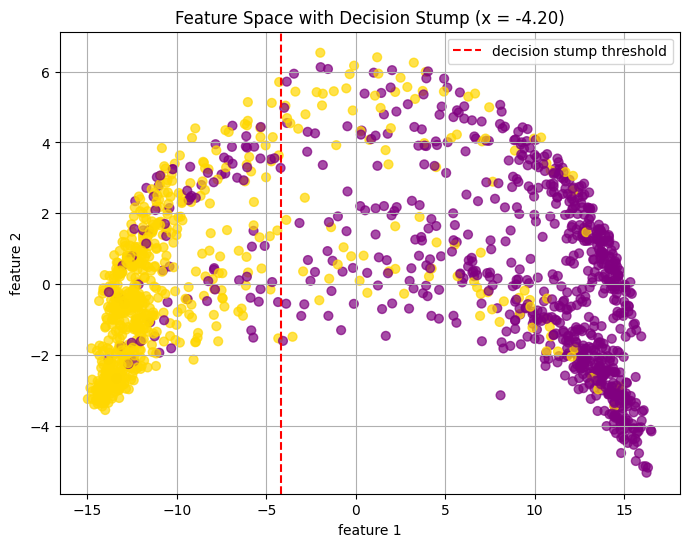

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(df['x'], df['y'], c=df['color'], s=40, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label='decision stump threshold')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title(f"Feature Space with Decision Stump (x = {best_thresh:.2f})")
plt.legend()
plt.grid(True)
plt.show()

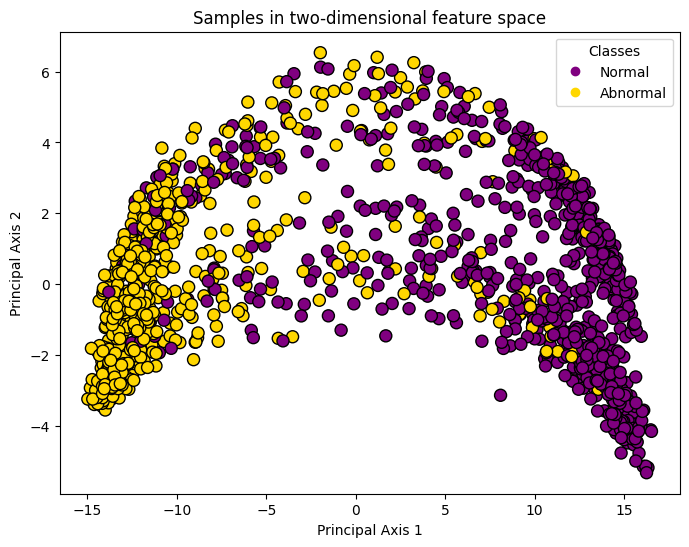

In [30]:
data_vis.plot_data(reduced_embeddings, labels)

Accuracy: 0.8751668891855807


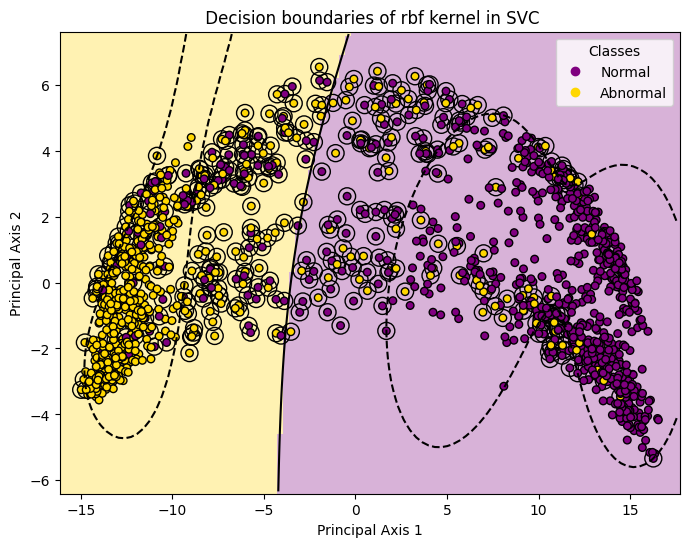

In [31]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", reduced_embeddings, labels)

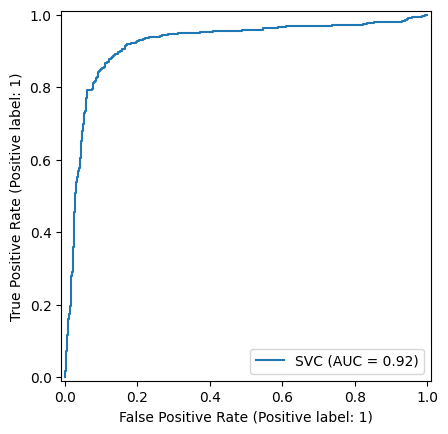

In [32]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()

In [33]:
from sklearn.decomposition import PCA

# Make sure `embeddings` is a 2D array / DataFrame of shape (n_samples, 768)
X = np.array(embeddings)

pca = PCA(n_components=8, random_state=42)
pcs = pca.fit_transform(X)

pc_cols = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]
pc_df = pd.DataFrame(pcs, columns=pc_cols)

# Attach label + image info so we can color/stratify plots
pc_df = pd.concat(
    [
        pc_df.reset_index(drop=True),
        db_df[['label', 'img_url', 'annotation_id']].reset_index(drop=True)
    ],
    axis=1
)

pc_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label,img_url,annotation_id
0,-14.060349,-3.150927,0.805410,2.901210,-0.971286,0.151446,-0.480921,0.222506,1,https://tools.alertcalifornia.org/fireframes5/...,34822
1,13.324792,-1.203738,0.133639,-0.243638,0.297745,-0.362851,-0.439984,0.729430,0,https://tools.alertcalifornia.org/fireframes5/...,37643
2,-12.324721,2.342059,0.371115,-2.202098,0.058240,-0.600244,-2.360822,-2.276173,0,https://tools.alertcalifornia.org/fireframes5/...,36384
3,11.755234,-1.605738,-2.605278,0.045543,-0.250033,0.850414,-0.828936,0.280548,0,https://tools.alertcalifornia.org/fireframes5/...,32612
4,0.763763,4.074392,-0.047540,-0.706563,-0.933670,-0.065844,2.527469,1.104197,1,https://tools.alertcalifornia.org/fireframes5/...,34290


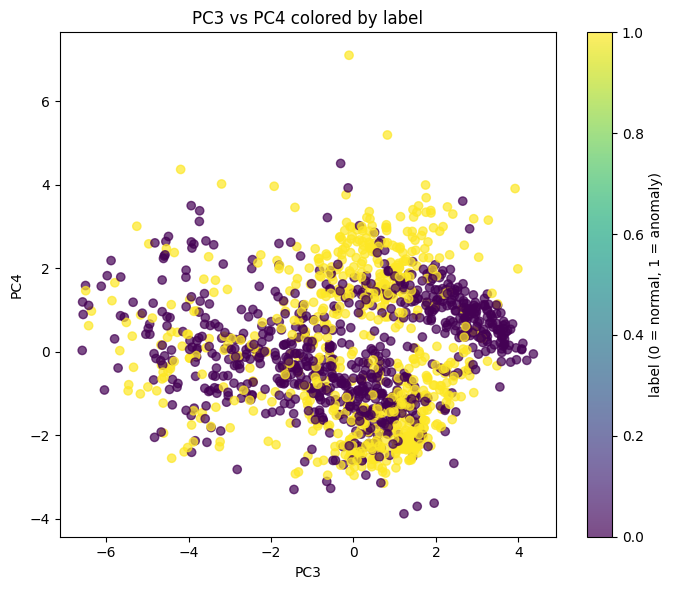

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    pc_df["PC3"],
    pc_df["PC4"],
    c=pc_df["label"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label (0 = normal, 1 = anomaly)")
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("PC3 vs PC4 colored by label")
plt.tight_layout()
plt.show()


In [35]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import colors as mpl_colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Work on a subset so you don't hammer the server ----
sample_size = min(400, len(pc_df))   # tweak if you want more/less
sampled = pc_df.sample(n=sample_size, random_state=0).copy()

# ---- 2. Function to compute image stats from URL ----
def compute_img_stats_from_url(url: str):
    try:
        # download image
        resp = requests.get(url, timeout=5)
        resp.raise_for_status()

        img = Image.open(BytesIO(resp.content)).convert("RGB")
        arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3) in [0,1]

        # basic luminance/contrast
        brightness = float(arr.mean())
        contrast = float(arr.std())

        # hue / saturation from HSV
        flat_rgb = arr.reshape(-1, 3)
        flat_hsv = mpl_colors.rgb_to_hsv(flat_rgb)
        hue_mean = float(flat_hsv[:, 0].mean())
        sat_mean = float(flat_hsv[:, 1].mean())

        return pd.Series(
            {
                "brightness": brightness,
                "contrast": contrast,
                "hue_mean": hue_mean,
                "sat_mean": sat_mean,
            }
        )
    except Exception as e:
        # if anything goes wrong, return NaNs so we can filter later
        return pd.Series(
            {
                "brightness": np.nan,
                "contrast": np.nan,
                "hue_mean": np.nan,
                "sat_mean": np.nan,
            }
        )

# ---- 3. Apply to the sample ----
stats = sampled["img_url"].apply(compute_img_stats_from_url)
sampled = pd.concat([sampled.reset_index(drop=True), stats.reset_index(drop=True)], axis=1)

# Drop rows where download failed
sampled = sampled.dropna(subset=["brightness", "contrast", "hue_mean", "sat_mean"])
print(f"Kept {len(sampled)} images with valid stats out of {sample_size} sampled.")

# ---- 4. Correlation of PC3/PC4 with image features ----
cols = ["PC3", "PC4", "brightness", "contrast", "hue_mean", "sat_mean"]
corr = sampled[cols].corr()

print("Correlation of PC3/PC4 with brightness / contrast / hue / saturation:\n")
print(corr.loc[["brightness", "contrast", "hue_mean", "sat_mean"], ["PC3", "PC4"]])

# ---- 5. Optional: quick visualization ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(sampled["PC3"], sampled["brightness"], alpha=0.5)
axes[0, 0].set_xlabel("PC3")
axes[0, 0].set_ylabel("brightness")

axes[0, 1].scatter(sampled["PC4"], sampled["brightness"], alpha=0.5)
axes[0, 1].set_xlabel("PC4")
axes[0, 1].set_ylabel("brightness")

axes[1, 0].scatter(sampled["PC3"], sampled["contrast"], alpha=0.5)
axes[1, 0].set_xlabel("PC3")
axes[1, 0].set_ylabel("contrast")

axes[1, 1].scatter(sampled["PC4"], sampled["contrast"], alpha=0.5)
axes[1, 1].set_xlabel("PC4")
axes[1, 1].set_ylabel("contrast")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Principal Component 3 appears to encode global image visibility and clarity.
PC3 shows strong negative correlations with brightness (–0.53), contrast (–0.48), color saturation (–0.52), and hue variation (–0.50). This suggests that PC3 increases when images are darker, less colorful, and lower-contrast, consistent with conditions such as fog, haze, nighttime, rain, or other forms of environmental degradation that reduce camera visibility.

Principal Component 4 shows only weak correlations with these image-level statistics, indicating it captures a more subtle structural or geometric feature of the scene rather than a simple illumination or color-based quality.